# **AUTO SEGMENT SATELLITE IMG WITH USING SAM, SAM-GEO AND LEAFMAP**

Auto segmenting the satellite image from the desired area of the google maps.

***Note: In order to get segmentation results project should be ran on GPU.***

## **Dependencies**

In [ ]:
%pip install segment-geospatial

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu

In [ ]:
import os
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

## **Create an interactive map**

In [ ]:
m = leafmap.Map(center=[39.868172829062935, 32.74906753495145], zoom=17, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[39.868172829062935, 32.74906753495145], controls=(ZoomControl(options=['position', 'zoom_in_text',…


**Use the draw tools to draw a polygon or rectangle on the map in order to segment an area.**

Note: If the project is running on Colab do not select an area that is too large because of the ram and gpu limitations.

In [ ]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [-122.2659, 37.8682, -122.2521, 37.8741]

## Download a sample image

In [ ]:
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


Display the downloaded image on the map.

In [ ]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(bottom=12718799.0, center=[39.87339282897356, 32.75392413139344], controls=(ZoomControl(options=['position…

## Initialize SAM class

Specify the file path to the model checkpoint. If it is not specified, the model will to downloaded to the working directory.

In [ ]:
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=None,
)

Model checkpoint for vit_h not found.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.56G/2.56G [00:16<00:00, 159MB/s]


## Automatic mask generation

Segment the image and save the results to a GeoTIFF file. Set `unique=True` to assign a unique ID to each object.

In [ ]:
sam.generate(image, output="masks.tif", foreground=True, unique=True)

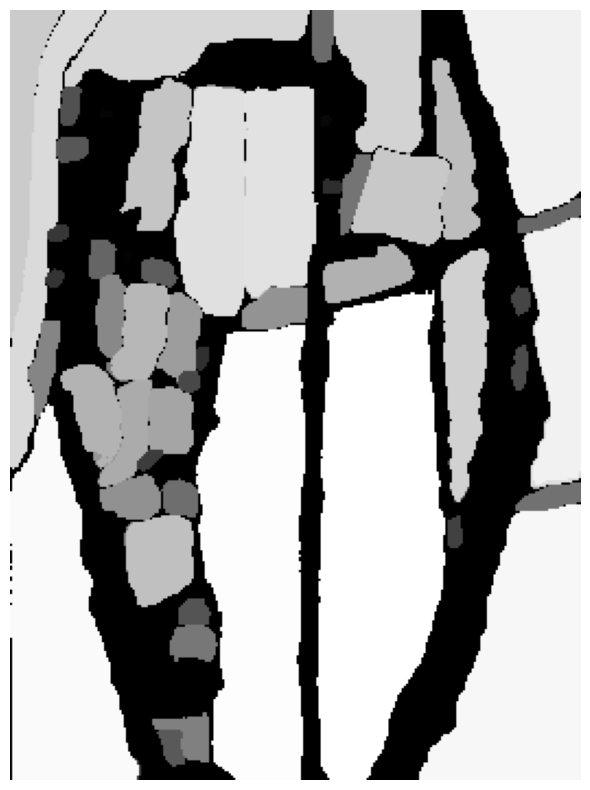

In [ ]:
sam.show_masks(cmap="binary_r")

Show the object annotations (objects with random color) on the map.

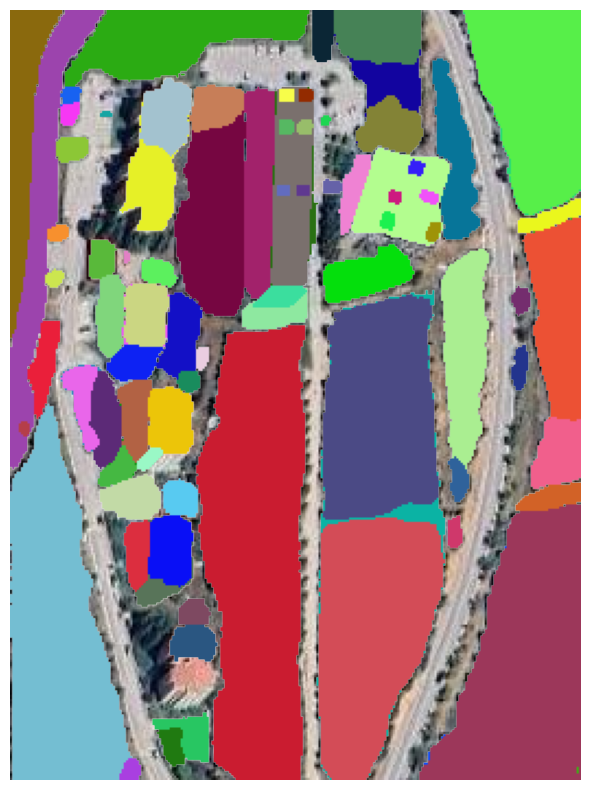

In [ ]:
sam.show_anns(axis="off", alpha=1, output="annotations.tif")

Compare images with a slider.


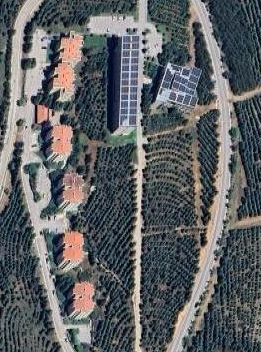
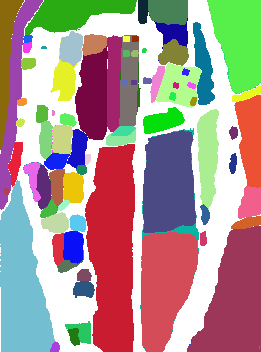

In [ ]:
leafmap.image_comparison(
    "satellite.tif",
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

Add image to the map.

In [ ]:
m.add_raster("annotations.tif", alpha=0.5, layer_name="Masks")
m

Map(bottom=25437111.0, center=[39.87375100634855, 32.75488436222077], controls=(ZoomControl(options=['position…

Convert the object annotations to vector format, such as GeoPackage, Shapefile, or GeoJSON.

In [ ]:
sam.tiff_to_vector("masks.tif", "masks.gpkg")

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

In [ ]:
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=sam_kwargs,
)

In [ ]:
sam.generate(image, output="masks2.tif", foreground=True)

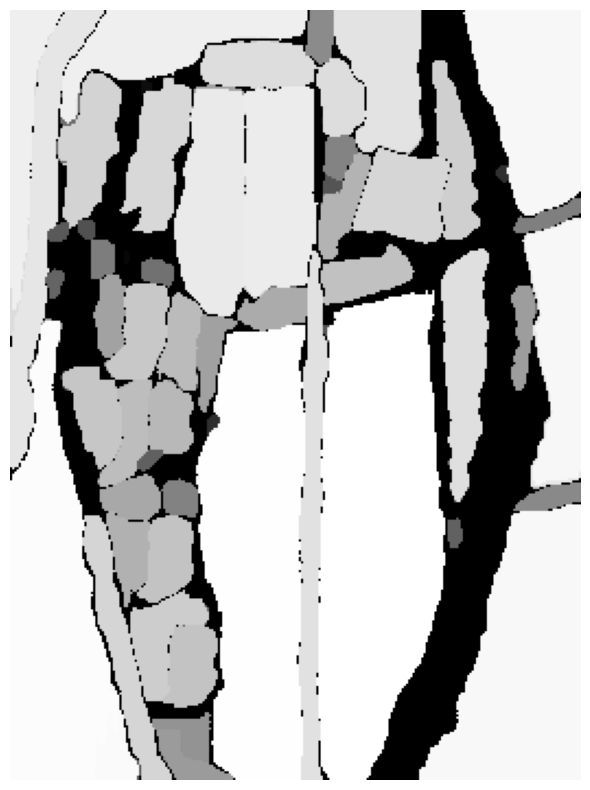

In [ ]:
sam.show_masks(cmap="binary_r")

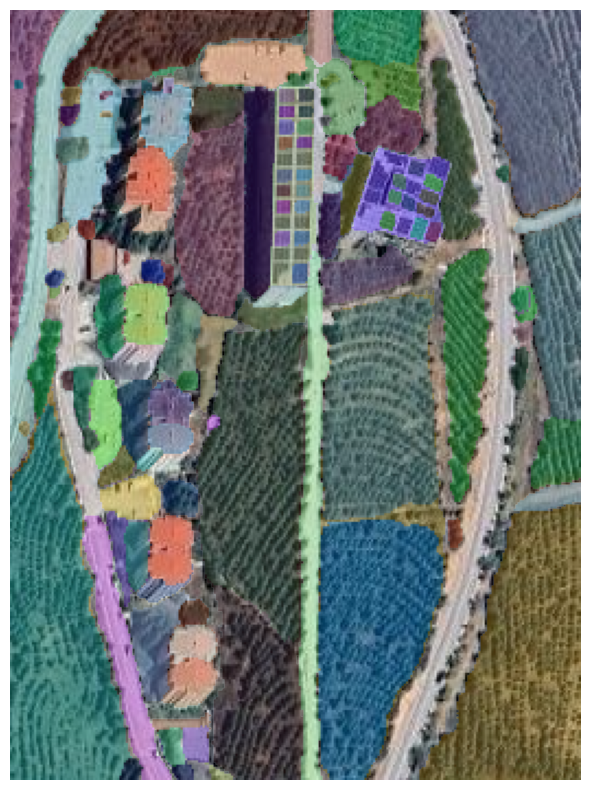

In [ ]:
sam.show_anns(axis="off", opacity=0.4, output="annotations2.tif")

Compare images with a slider.


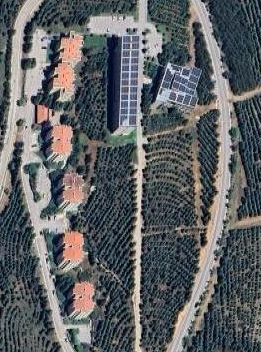
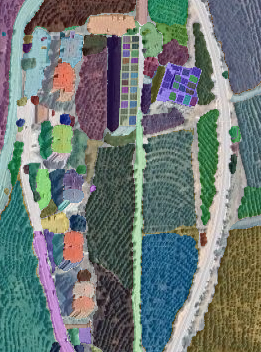

In [ ]:
leafmap.image_comparison(
    image,
    "annotations2.tif",
    label1="Image",
    label2="Image Segmentation",
)

Overlay the annotations on the image and use the slider to change the opacity interactively.

In [ ]:
overlay_images(image, "annotations2.tif", backend="TkAgg")

The TkAgg backend is not supported in Google Colab. The overlay_images function will not work on Colab.
